In [1]:
import math

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from models.lm import LM
from models.transformer.transformer import TransformerConfig

from data import OthelloDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
d_model = 512
n_layers = 8
n_heads = 8

B = 64

dropout = 0.
bias = False

lr = 5e-4 # todo : up BS and LR
lr_min = 1e-5
lr_warmup_iter = 100
lr_decay_iter = 10000 # max_iters as in chinchilla

adam_b1 = 0.9
adam_b2 = 0.95

clip_value_grad = 1.0
weight_decay = 0.1

In [19]:
ds = OthelloDataset()
loader = torch.utils.data.DataLoader(ds, batch_size=B, num_workers=0, pin_memory=True)

In [20]:
config = TransformerConfig(d_model=d_model, n_layers=n_layers, n_heads=n_heads, dropout=dropout, bias=bias, max_len=60, flash=True)
model = LM(config, vocab_size=65).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr, betas=(adam_b1, adam_b2), weight_decay=weight_decay)

sum([p.numel() for p in model.parameters()])

33627136

In [21]:
# cosine with warmup (taken from @karpathy)
def get_lr(it):
    if lr_decay_iter == 0:
        return lr
    
    # 1) linear warmup for warmup_iters steps
    if it < lr_warmup_iter:
        return lr * it / lr_warmup_iter
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iter:
        return lr_min
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - lr_warmup_iter) / (lr_decay_iter - lr_warmup_iter)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return lr_min + coeff * (lr - lr_min)

In [22]:
losses = []
scaler = torch.cuda.amp.GradScaler()

In [23]:
for iter, data in enumerate(loader):
    x, y = data
    x, y = x+1, y+1 # todo : change dataset
    x = x.int().to(device)
    y = y.long().to(device)

    with torch.autocast(device, torch.float16):
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=0) # todo : move loss ?

    scaler.scale(loss).backward()
    scaler.unscale_(optim)
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=clip_value_grad)
    scaler.step(optim)
    scaler.update()
    optim.zero_grad()

    # lr decay
    lr_iter = get_lr(iter)
    for param_group in optim.param_groups:
        param_group['lr'] = lr_iter

    losses.append(loss.item())

    if iter >= 500:
        break

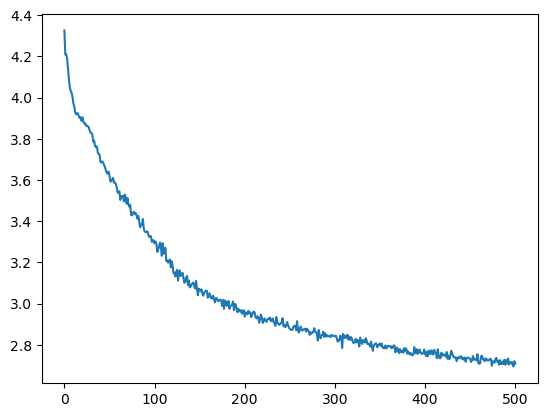

In [24]:
plt.plot(losses)

In [25]:
losses[-1]

2.708470582962036

In [26]:
# evaluate move legality

In [27]:
model.eval()

LM(
  (embedding): Embedding(65, 512, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(60, 512)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-7): 8 x DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=512, out_features=512, bias=False)
          (key_proj): Linear(in_features=512, out_features=512, bias=False)
          (value_proj): Linear(in_features=512, out_features=512, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=512, out_features=2048, bias=False)
          (fc_2): Linear(in_features=2048, out_features=512, bias=False)
          (fc_3): Linear(in_features=512, out_features=2048, bias=False)
          (dropout): 

In [28]:
import random
from othello import OthelloGame

In [29]:
ds_val = OthelloDataset(dir="data/val")
loader_val = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, pin_memory=True)

In [30]:
total_moves = 0
total_legal_moves = 0

for i, data in enumerate(loader_val):
    game_transcript, _ = data # (1, lengame)
    game_transcript = game_transcript.squeeze().int().to(device) # if sent to model : +1 and -1 after the pass

    game_len = game_transcript.shape[0] # always 60-1=59 (padded)
    game = OthelloGame()
    game.play_move(game_transcript[0].item())
    for pgame_len in range(1, game_len):
        context = game_transcript[:pgame_len]

        # get legal moves given current game board
        legal_moves = game.get_valid_moves()
        if legal_moves == []:
            break
        
        # sample a move
        x = (context+1)[None, ...] # (1, pgame_len)
        logits = model(x)[:, -1, :] # (1, vocab_size)
        probs = F.softmax(logits, dim=-1) # (1, vocab_size)
        move = torch.multinomial(probs, num_samples=1).item()-1

        if move in legal_moves:
            total_legal_moves += 1
        total_moves += 1

        game.play_move(game_transcript[pgame_len].item())

    if i >= 50:
        break

In [31]:
f"legal move accuracy : {100*total_legal_moves/total_moves}%"

'legal move accuracy : 61.25084976206662%'